# A journey into Convolutional Neural Network visualisation 

There is one famous urban legend about computer vision. Around the 80s, the US military wanted to use neural networks to automatically detect camouflaged enemy tanks. They took a number of pictures of trees without tanks and then pictures with the same trees with tanks behind them.
The results were impressive. So impressive that the army wanted to be sure the net had correctly generalized. They took new pictures of woods with and without tanks and they showed them again to the network. This time, the model performed terribly, it was not able to discriminate between pictures tanks behind woods and just trees. It turned out, that all the pictures with of plain woods were taken on a cloudy day while the ones with tanks on a sunny day! In reality, the network lean to recognize the weather, not the enemy tanks.

With this article, we are going to see different techniques to *understand* what it is going on inside a Convolutional Neural Network to avoid making the same US' army mistake.
 
We are going to use [Pytorch](https://pytorch.org/). All the code can be found [here](https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-). Most of the visualizations were developed from scratch, however, some inspiration and parts were taken from [here](https://github.com/utkuozbulak/pytorch-cnn-visualizations/tree/master/src)

We will first introduce each technique by briefly explain it and making some example and comparison between different classic computer vision models, `alexnet`, `vgg16` and `resnet`. Then we will try to better understand a model used in robotics to avoid obstacles using frontal camera's images.

Our goal is not to explain in detail how each technique works, even if some of them are very simple since this is already done by each paper. But to use them to help the reader visualize different model with different inputs to better understand and highlight what and how different models see an input. For example, we will see with features in the input image is used to understand that it contains a cat.

# Preambula
Let's start our journey by selecting some images to be used as inputs. We are first going to fire up `alexnet` to start exploring the first technique.

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from torchvision.models import *
from visualisation.core.utils import device

model = alexnet(pretrained=True).to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

Now we need some inputs

In [3]:
# %matplotlib notebook

In [4]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch 

from PIL import Image

plt.rcParams["figure.figsize"]=7,7


In [5]:
def tensor2img(tensor, ax=plt):
    tensor = tensor.squeeze()
    if len(tensor.shape) > 2: tensor = tensor.permute(1, 2, 0)
    img = tensor.detach().cpu().numpy()
    return img

In [6]:
def subplot(images, parse=lambda x: x, rows_titles=None, cols_titles=None, title='', *args, **kwargs):
    fig, ax = plt.subplots(*args, **kwargs)
    fig.suptitle(title)
    i = 0
    try:
        for row in ax:
            if rows_titles is not None: row.set_title(rows_titles[i])
            try:
                for j,col in enumerate(row):
                    if cols_titles is not None:  col.set_title(cols_titles[j])
                    col.imshow(parse(images[i]))
                    col.axis('off')
                    col.set_aspect('equal')
                    i += 1
            except TypeError:
                row.imshow(parse(images[i]))
                row.axis('off')
                row.set_aspect('equal')
                i += 1
            except IndexError:
                break
    except:
        ax.imshow(parse(images[i]))
        ax.axis('off')
        ax.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0)


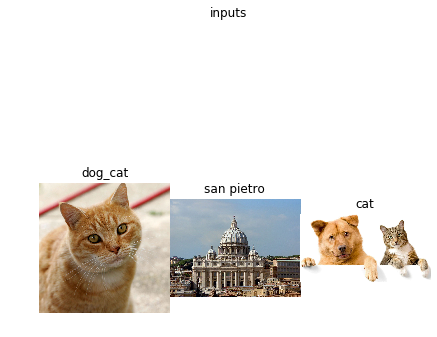

In [7]:
import glob
import matplotlib.pyplot as plt
import numpy as np

from visualisation.core.utils import device 
from PIL import Image

image_paths = glob.glob('./images/*.*')

images = list(map(lambda x: Image.open(x), image_paths))

subplot(images, title='inputs', rows_titles=['dog_cat','san pietro','cat'], nrows=1, ncols=3)

plt.show()

As inputs we are going to use an image with two classes, `dog` and `cat`, the beautiful Basilica of San Pietro and a `cat`. We know need to parse them and preprocess by normalize them since all of our models were trained on [imagenet](http://www.image-net.org/) a huge dataset with `1000` different classes.

In [8]:
from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
from visualisation.core import *
from visualisation.core.utils import image_net_preprocessing

inputs  = [Compose([Resize((224,224)), ToTensor(), image_net_preprocessing])(x).unsqueeze(0) for x in images]  # add 1 dim for batch
inputs = [i.to(device) for i in inputs]

We will also need the human readable label for each class

In [9]:
imagenet2human = {}
with open('imaganet2human.txt') as f:
    for line in f.readlines():
        key, value = line.split(':')
        key = key.replace('{', '').replace('}', '') # I forget how regex works :) 
        value = value.replace("'", '').replace(",", '')
        imagenet2human[int(key.strip())] = str(value.strip())
        
list(imagenet2human.items())[:2]

[(0, 'tench Tinca tinca'), (1, 'goldfish Carassius auratus')]

# Weights Visualisation
The first straightforward visualization is to just plot the weights of a target Layer. Obviously, the deeper we go the smaller each the image becomes while the channels number increases and the weight and height decrease. We are going to show each channel as a grey array image. Unfortunately, each Pytorch module can be nested and nested, so to make our code as general as possible we first need to trace each sub-module the input traverse and then store each layer in order. We first need to `trace` our model to get a list of all the layers so we can selecet a target layer without following the nested structure of a model. Remember, `PyTorch` models can be infinitively nested. In other words, we are flatted the model's layers.

In [10]:
def module2traced(module, inputs):
    handles, modules = [], []
        
    def trace(module, inputs, outputs):
        modules.append(module)
    
    def traverse(module):
        for m in module.children():
            traverse(m)
        is_leaf = len(list(module.children())) == 0
        if is_leaf: handles.append(module.register_forward_hook(trace))
        
    traverse(module)
    
    _ = module(inputs)
    
    [h.remove() for h in handles]
    
    return modules

In [11]:
modules = module2traced(model, inputs[0])
modules

[Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
 ReLU(inplace),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 ReLU(inplace),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Dropout(p=0.5),
 Linear(in_features=9216, out_features=4096, bias=True),
 ReLU(inplace),
 Dropout(p=0.5),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace),
 Linear(in_features=4096, out_features=1000, bias=True)]

Let's plot the first layer

In [12]:
vis = Weights(model, device)

torch.Size([1, 55, 55])


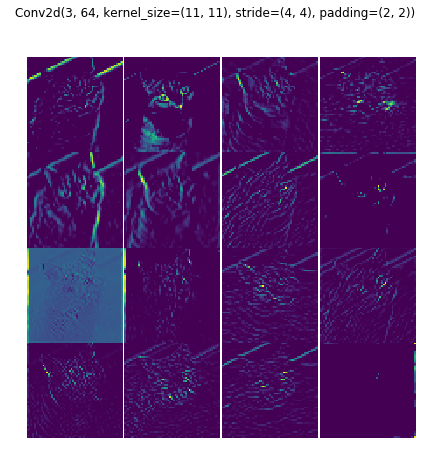

In [13]:
first_layer = modules[0]

def run_vis_plot(vis, x, layer, ncols=1, nrows=1):
    images, info = vis(x, layer)
    images = images[: nrows*ncols]
    print(images[0].shape)
    subplot(images, tensor2img, title=str(layer), ncols=ncols, nrows=nrows)
    
run_vis_plot(vis, inputs[0], first_layer, ncols=4, nrows=4)

Let's stop for a minute to explain what those images represent. We traced the input through the computational graph in order to find out all the layers of our models, in this case, `alexnet`. Then we used the `Weights` class implemented in `visualisation.core` and we call it by passing the current input, the **cat and dog** image, and the **target layer**. As outputs, we get all the current layer's weights as grey images. Then, we plot 16 of them. We can notice that they, in some way, makes sense. Some pixels are brighter at the edges of the images.

Let's plot the first `MaxPool` layer to better see this effect. We should also see a dimensional reduction with some higher brightness pixels in some interesting areas.

torch.Size([1, 27, 27])


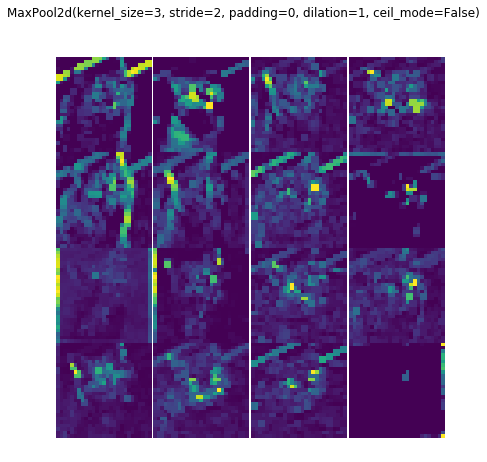

In [14]:
first_maxpool_layer = modules[2]

run_vis_plot(vis, inputs[0], first_maxpool_layer, ncols=4, nrows=4)

Let's try with an other input, the San Pietro Basilica

torch.Size([1, 27, 27])


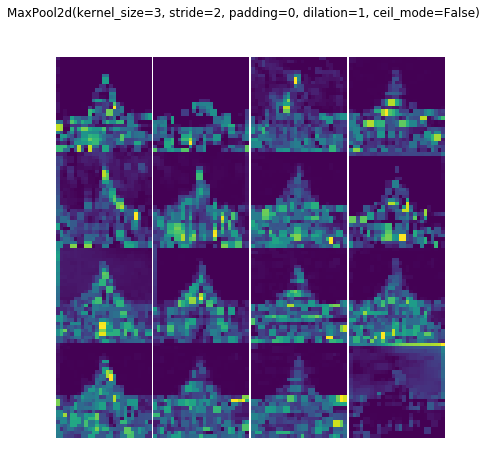

In [15]:
run_vis_plot(vis, inputs[1], first_maxpool_layer, ncols=4, nrows=4)

Same story. These images make somehow sense, they highlight the basilica layout but it is hard to understand what the model is actually doing. We got the idea that is computing something correctly but we could ask some questions, for example: is it looking at the cupola? Which are the most important features of the Basilica?

Moreover, the deeper we go the harder it becomes to even recognize the input. 

torch.Size([1, 13, 13])


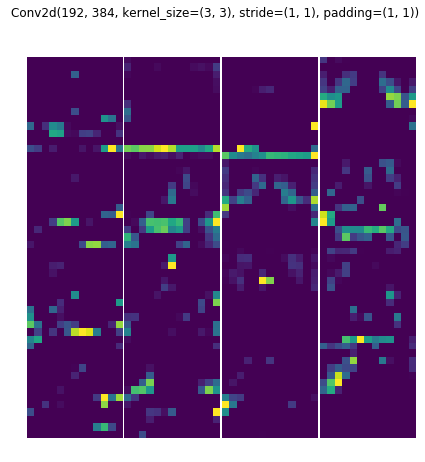

In [16]:
deeper_layer = modules[6]
run_vis_plot(vis, inputs[1], deeper_layer, ncols=4, nrows=4)

In this case, we have no idea of what these images should represent. It can be argued that weights visualization does not carry any useful information about the model, even if this is almost true, there is one main advantage of plotting the weights especially at the first layer. Let's see

torch.Size([1, 55, 55])
torch.Size([1, 55, 55])


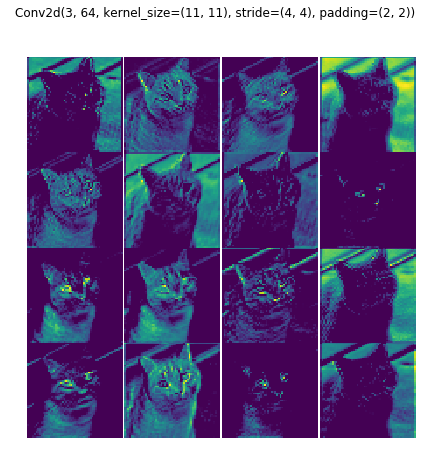

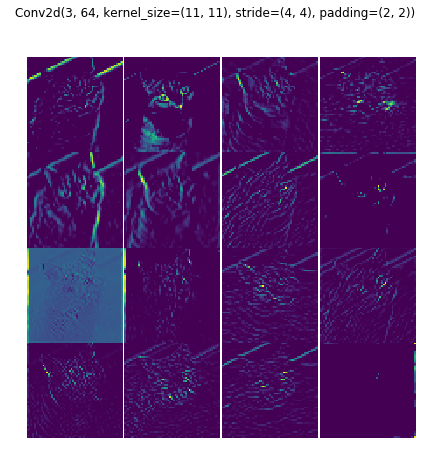

In [17]:
alexnet_not_pretrained = alexnet(pretrained=False).to(device)

run_vis_plot(Weights(alexnet_not_pretrained, device), 
             inputs[0], 
             module2traced(alexnet_not_pretrained, inputs[0])[0],
             ncols=4, nrows=4)

alexnet_pretrained = alexnet(pretrained=True).to(device)

run_vis_plot(Weights(alexnet_pretrained, device), 
             inputs[0], 
             module2traced(alexnet_pretrained, inputs[0])[0],
             ncols=4, nrows=4)

del alexnet_not_pretrained
del alexnet_pretrained

torch.cuda.empty_cache()

When a model is poorly trained or not trained at all, the first weights have lots of noise, since they are just randomly initialized, and they are a lot more similar to the inputs images than the trained weights. This feature can be useful to understand on the fly is a model is trained or not. However, except for this, weights visualization is not the way to go to understand what a CNN is doing.

## Similarities with other models

We have seen `alexnet`, but are the weights similar across model? 

In [18]:
def run_vis_plot_across_models(modules, input, layer_id, Vis, title, 
                               inputs=None, 
                               nrows=3, 
                               ncols=2, 
                               row_wise=True, 
                               parse=tensor2img,
                               annotations=None,
                               rows_name=None,*args, **kwargs):
    pad = 0 # in points
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    fig.suptitle(title)       
    for i, row in enumerate(ax):
        try:
            module = next(modules)
            module.eval()
            module = module.to(device)
            layer = None
            if layer_id is not None: layer = module2traced(module, input)[layer_id]
            vis = Vis(module, device)
            info = {}
            if inputs is None: images, info = vis(input.clone(), layer, *args, **kwargs)
            row_title = module.__class__.__name__
            if rows_name is not None: row_title = rows_name[i]
            row[0].set_title(row_title)
            if annotations is not None: 
                row[0].annotate(annotations[i], xy=(0, 0.5), xytext=(-row[0].yaxis.labelpad - pad, 0),
                    xycoords=row[0].yaxis.label, textcoords='offset points',
                    size='medium', ha='right', va='center', rotation=90)
            for j, col in enumerate(row):
                if inputs is None: image = images[j]
                else: image, info = vis(inputs[j], layer, *args, **kwargs)
                if 'prediction' in info: col.set_title(imagenet2human[int(info['prediction'])])
                col.imshow(parse(image))
                col.axis('off')
                col.set_aspect('equal')
        except StopIteration:
            break
        except:
            row.set_title(row_title)
            row.imshow(parse(images[0]))
            row.axis('off')
            row.set_aspect('equal')
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.2)



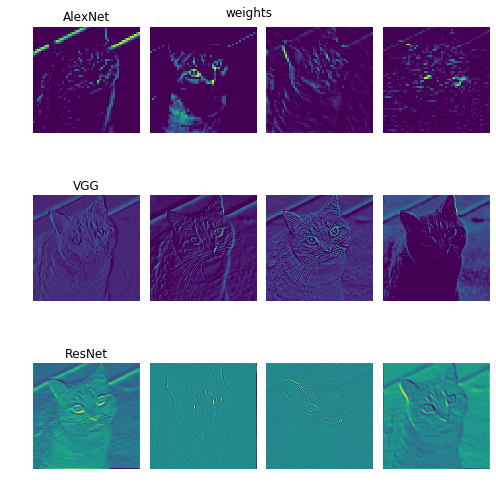

In [19]:
N_IMAGES = 4
size = (4, 1) # show 4 image per row

modules_instances = [alexnet, vgg16, resnet34]

modules = (m(pretrained=True).to(device) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once

run_vis_plot_across_models(modules, inputs[0], 0, Weights , 'weights', ncols=4)


The `resnet` and `vgg` weights looks more similar to the input images than `alexnet`. But, again, what does it mean?

# Saliency Visualisation
One idea proposed by [*Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps*](https://arxiv.org/abs/1312.6034) is to back-prop the output of the network with respect to a target class until the input. This will highligh the part of the image responsible for that class. Let's start with alexnet.

Let's first print the prediction of the network (this could change if you re-run the cell)

In [20]:
model.eval()
pred = model(inputs[0])
_, id = torch.max(pred, 1)

print('predicted class {}'.format(imagenet2human[id.item()]))

predicted class tiger cat


Each visualisation is implemented in its own class. You can find the code [here] . It will backpropr the outpad with respect to the one hot encoding representation of the number corresponding to `collie` in our case `231`

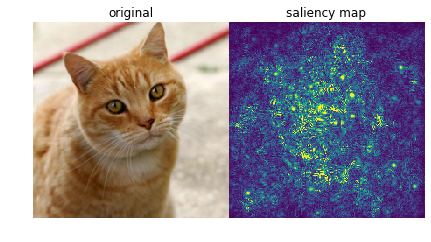

In [21]:
from visualisation.core.utils import image_net_postprocessing
model.eval()
model = model.to(device)
vis = SaliencyMap(model, device)

out, info = vis(inputs[0], 
          first_layer,
          target_class=231)

subplot([image_net_postprocessing(inputs[0].squeeze().cpu()), out], 
        rows_titles=['original', 'saliency map'],
        parse=tensor2img, 
        nrows=1, ncols=2)


We can see that `alexnet` get exited most on the dog. We can even do better! We can set to `0` each **negative** relu gradient when backprop. This is techinique is called `guided`.

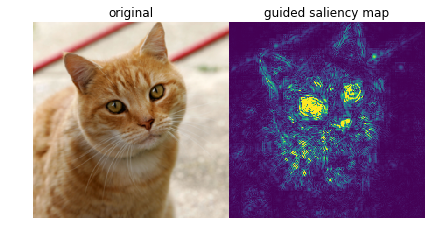

In [22]:
out, info = vis(inputs[0], 
          first_layer,
          guide=True,
          target_class=231)

subplot([image_net_postprocessing(inputs[0].squeeze().cpu()), out], 
        rows_titles=['original', 'guided saliency map'],
        parse=tensor2img, 
        nrows=1, ncols=2)

Now we can clearly see that the network is looking at the eyes and the nose of the dog. We can try to compare different models

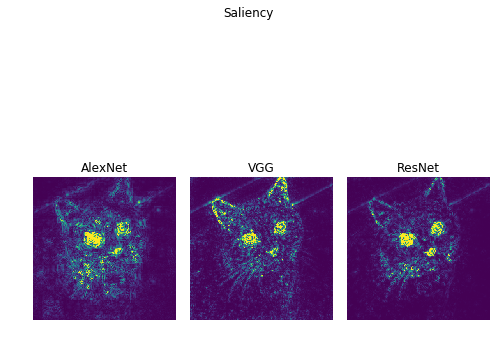

In [23]:
modules = (m(pretrained=True).to(device) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once

run_vis_plot_across_models(modules, inputs[0], 0, SaliencyMap , 'Saliency', nrows=1, ncols=3, target_class=231, guide=True)


`Alextnet` seems more interested to the dog, while `VGG` and `Resnet` also look at the ears and eyes of the cat. 
While guiding yields a better human interpebable image, the vanilla implementation can be used for localizing an object of interest. In other words, we can find object of interest for free by cropping out of the input image the region corresponding to the gradient. Let's plot each input image for each model

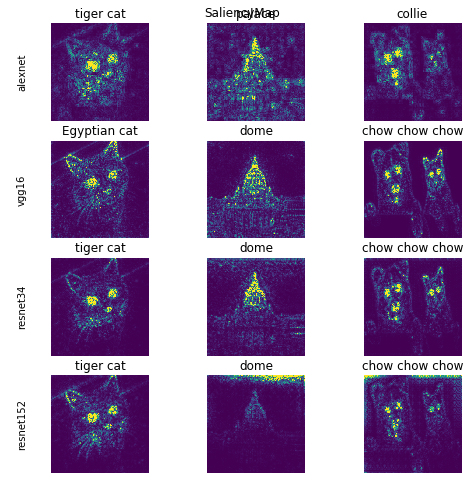

In [24]:
modules_instances = [alexnet, vgg16, resnet34, resnet152]

modules = (m(pretrained=True) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once


run_vis_plot_across_models(modules, inputs[0], None, SaliencyMap , 'SaliencyMap', 
                           nrows=4, 
                           ncols=3, 
                           inputs=inputs,
                           annotations=['alexnet', 'vgg16', 'resnet34', 'resnet152'],
                           guide=True)


# Class Activation Mapping
*Class Activation Mapping* is a techniques presented in [Learning Deep Features for Discriminative Localization](https://arxiv.org/pdf/1512.04150.pdf). The idea is to use the last convolutional layer output and the neurons in the linear layer of the model responsable for a target class, the map is generated by taking the dot product of those. However, to make this work the model has to have some constrains. First of all, the output form the convolution must first go trought an **global average polling** and it requires feature maps to directly precede softmax layers. To make it works with other architecture, such as `alexnet` and `vgg` we have to change some layers in the model and retrain it. This is a major drawback that will be solved with the next section. For now, we can use it for free with resnet

![alt](https://raw.githubusercontent.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-/master/resources/images/class_activation_mapping1.png)

By changing the target class, we can see different part of the image highlighted. The first image uses the prediction class, while the second `cat` and the last one  `bookcase`, just to see what the model will do with a wrong class.

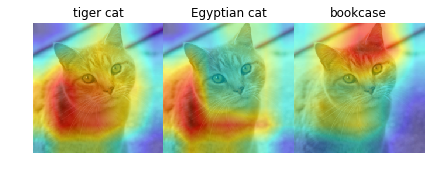

In [25]:
from visualisation.core.utils import imshow
# we are using resnet 34 since the model has only one fc layer before the softmax and it is preceded by av avg pool
# as required from the paper
module = resnet34(True).to(device)
module.eval()

vis = ClassActivationMapping(module, device)

classes = [None, 285, 453]

def vis_outs2images_classes(outs):
    images = [x[0] for x in outs]
    classes = [imagenet2human[int(x[1]['prediction'])] for x in outs]
    
    return images, classes

outs = [vis(inputs[0], None, 
          postprocessing=image_net_postprocessing, 
          target_class=c,
          guide=True) for c in classes]

images, classes = vis_outs2images_classes(outs)

subplot(images, 
        rows_titles=classes,
        nrows=1, 
        ncols=3, 
        parse=tensor2img)

Let's plot the CAM for the `cat` for different `resnet` architecture. For resnet > 34 the `Bottleneck` module is used

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


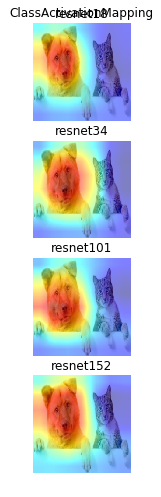

In [26]:
modules_instances = [resnet18, resnet34, resnet101, resnet152]

cat = inputs[2]

modules = (m(pretrained=True).to(device) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once

run_vis_plot_across_models(modules, cat, None, 
                           ClassActivationMapping , 
                           'ClassActivationMapping', 
                           nrows=len(modules_instances),
                           ncols=1,
                           postprocessing=image_net_postprocessing, 
                           rows_name = ['resnet18', 'resnet34', 'resnet101', 'resnet152'],
                           target_class=None)

They are all very similar as espected. One big drawback of this technique is that force you to use a network with a specific architecture, global polling before the decoder part. The next technique generalise this approach by taking advantage of the gradient at one specific layer. Remember that with the *class activation* we are using the weights of the weights of the feature map as scaling factor for the channels of the last layer. The features map must be before a softmax layer and right after the average pooling.

# Grad Cam

**Grad Cam** was introduced by [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391). The idea is actually simple, we backprop the output with respect to a target class while storing the gradient and the output at a given layer, in our case the last convolution. Then we perform a global average of the saved gradient keeping the channel dimension in order to get a 1-d tensor, this will represent the importance of each channel in the target convolutional layer. We then multiply each element of the convolutional layer outputs by the averaged gradients to create the grad cam. This whole procedure is fast and it is architecture independent. Interesting, the authors show that is a generalization of the previous technique.


![alt](https://raw.githubusercontent.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-/master/resources/images/grad_cam1.png)

We can use it to higlight what different models are looking at.

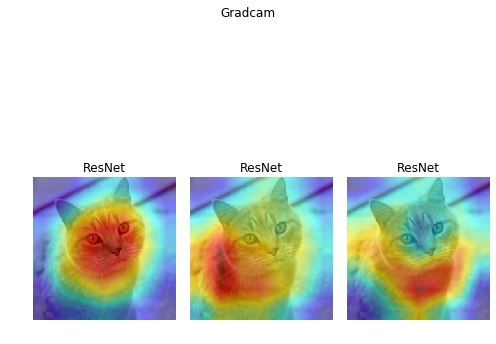

In [27]:
modules = (m(pretrained=True).to(device) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once

run_vis_plot_across_models(modules, inputs[0], None, GradCam , 'Gradcam', 
                           nrows=1, 
                           ncols=3, 
                           target_class=None, 
                           postprocessing=image_net_postprocessing)


It is really interesting to see how Alexnet looks at the upper nose and the eye, whiile vgg at the nose and restnet at the whole dog. We can also others target classes as we did before.

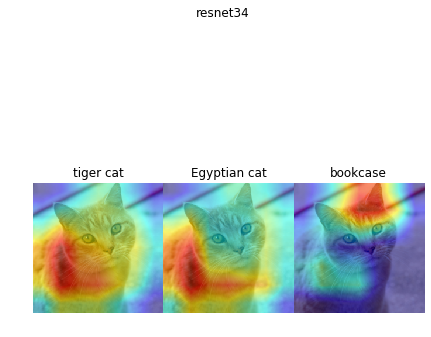

In [28]:
from visualisation.core.utils import imshow

module = module.to(device)

vis = GradCam(module, device)

classes = [None, 285, 453]
outs = [vis(inputs[0], None, 
          postprocessing=image_net_postprocessing, 
          target_class=c) for c in classes]

images, classes = vis_outs2images_classes(outs)

subplot(images,
        title='resnet34',
        rows_titles=classes,
        nrows=1, 
        ncols=len(outs), 
        parse=tensor2img)

Notice how similar to the `CAM` output they are. We can now plot the grad cam for each input with respect to each model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


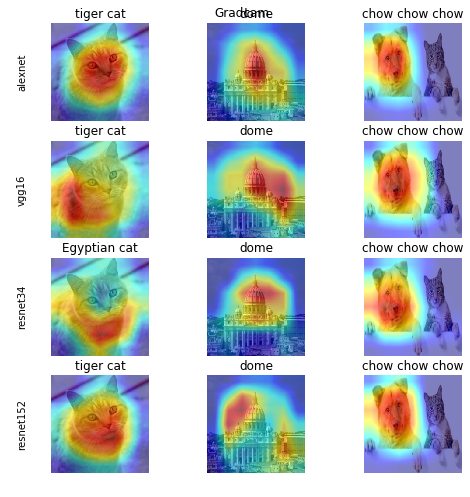

In [29]:
modules = (m(pretrained=True).to(device) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once

run_vis_plot_across_models(modules, inputs[0], None, GradCam , 'Gradcam', 
                           nrows=4, 
                           ncols=3, 
                           target_class=None, 
                           inputs=inputs,
                           annotations=['alexnet', 'vgg16', 'resnet34', 'resnet152'],
                           postprocessing=image_net_postprocessing)


The reader can immediately notice the difference across the models.

We talk before about interesting region localizations. Grad-cam can be also used to extract the class object out of the image. Easily, once the have the grad-cam image we can used it as mask to crop out form the input image what we want.

In [30]:
vis = GradCam(model, device)

_ = vis(inputs[0], None, 
          postprocessing=image_net_postprocessing)


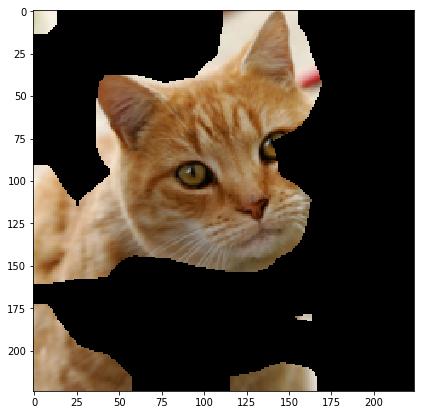

In [31]:
import cv2

def gradcam2crop(cam, original_img):
    b, c, w, h = inputs[0].shape
    cam = cam.numpy()
    cam -= np.min(cam)
    cam /= np.max(cam) 
    
    cam = cv2.resize(cam, (w,h))
    mask = cam > 0.3

    original_img = tensor2img(image_net_postprocessing(original_img[0].squeeze()))

    crop = original_img.copy()
    crop[mask == 0] = 0
    
    return crop

crop = gradcam2crop(vis.cam.cpu(), inputs[0].cpu())

fig = plt.figure()
plt.imshow(crop)

*et voilà*! We can also change again class, and crop the interest region for that class.

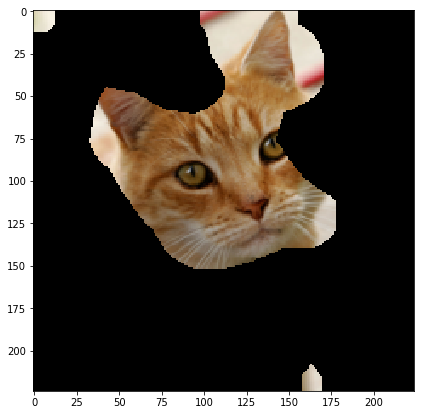

In [32]:
_ = vis(inputs[0], None, 
        target_class=284,
          postprocessing=image_net_postprocessing)

crop = gradcam2crop(vis.cam.cpu(), inputs[0].cpu())

fig = plt.figure()
plt.imshow(crop)

## Different models

We have seen all these techniques used with classic classicification models trained on `imagenet`. What about use them on a different domain? I have ported this paper to Pytorch and retrain it. The model learn from the frontal camera's image of a robot to predict the local distance sensors in order to avoid obstacles. Let's see what if, by using those techniques, we can understand better what is going on inside the model.

### Learning Long-range Perception using Self-Supervision from Short-Range Sensors and Odometry

The idea is to predict the future outputs of a short-range sensor (such as a proximity sensor) given the current outputs of a long-range sensor (such as a camera). They trained a very simple CNN from the robot's camera images to predict the proximity sensor values. If you are interested in their work, you can read the full paper [here](https://arxiv.org/abs/1809.07207)

![alt](https://raw.githubusercontent.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-/master/resources/images/long_range_perception.png)

I have made a PyTorch implementation andd retrain the model from scratch. Be awere that I did not fine-tune or try different sets of hyper-parameters so probably my model is not performing as well as the author's one.

Let's import it

In [33]:
from os import path

LONG_RANGE_PERCEPTION_PATH = path.abspath('./models/long_range_perception/model.pt')

In [34]:
from models.long_range_perception.model import SimpleCNN
from models.long_range_perception.utils import get_dl, H5_PATH, imshow, post_processing, pre_processing, MODEL_PATH

module = torch.load(LONG_RANGE_PERCEPTION_PATH, map_location=lambda storage, loc: storage)

module = module.to(device)
module

/home/francesco/Documents/A-journey-into-Convolutional-Neural-Network-visualization-/model.pt


SimpleCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(10, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Dropout(p=0.2)
    (1): Linear(in_features=640, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=325, bias=True)
    (4): Sigmoid()
  )
)

We know need some inputs to test the model, they are taken directly from the **test set**

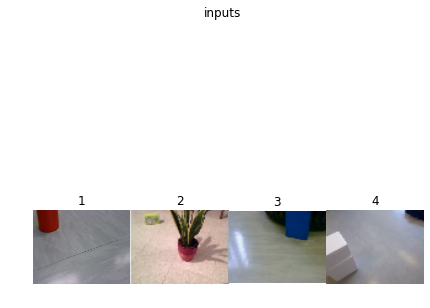

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


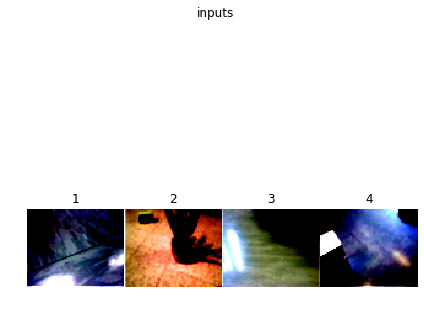

In [35]:
import os 

def make_and_show_inputs(path, transform):
    image_paths = glob.glob(path)
    image_paths = filter(lambda x: os.path.isfile(x), image_paths)

    images = list(map(lambda x: Image.open(x).convert('RGB'), image_paths))

    subplot(images, title='inputs', rows_titles=['1','2','3','4'], nrows=1, ncols=4)

    plt.show()
    
    inputs  = [pre_processing(x).unsqueeze(0).to(device) for x in images]  # add 1 dim for batch

    subplot(inputs, parse=tensor2img, title='inputs', rows_titles=['1','2','3','4'], nrows=1, ncols=4)

    return images, inputs
    
images, inputs = make_and_show_inputs('images/long_range_perception/*', pre_processing)

Then author normalize each image, this is done by callind `pre_processing`

We are going to use the `SaliencyMap` and the `GradCam` since those are the best

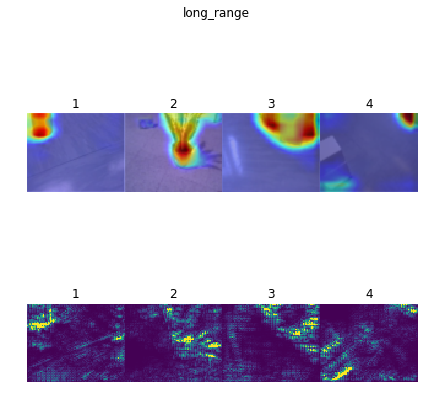

In [36]:
from torch.autograd import Variable

module.eval()

def run_long_range_vis():
    grad = GradCam(module, device)

    all_true = torch.ones(1,65*5).float().to(device)

    outs_grad = [grad(input, None, target_class=all_true, 
                      postprocessing=post_processing, 
                      regression=True)[0] for input in inputs]

    sal = SaliencyMap(module, device)

    outs_saliency = [sal(input, None, guide=True, target_class=all_true,
                        regression=True)[0] for input in inputs]

    subplot([*outs_grad, *outs_saliency],
            title='long_range',
            cols_titles=['1','2','3','4'],
            nrows=2, 
            ncols=4, 
            parse=tensor2img)
    
run_long_range_vis()

We can clearly see that the model looks at the objects. In the `GradCam` row, on the second picture the plan is basically segmented by the heatmap. There is one problem, if you look at the third picture, the white box in front of the camera is not clearly highlighted. This is probably due to the white color of the floor that is very similar to the box's color. Let's investigate this problem. 

In the second row, the `SaliencyMaps` highlights all the objects, including the white box. The reader can notice that the reflection in the first picture on the left seems to excitate the network in that region. We should also investigate this other case to be sure the model is robut.


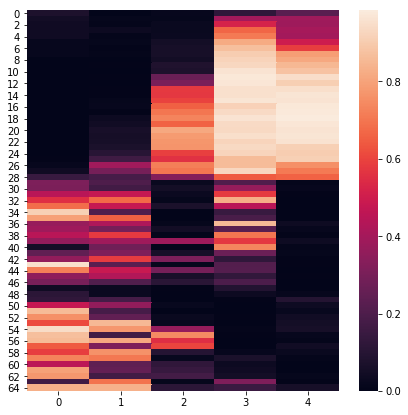

In [37]:
import seaborn as sns 

module.eval()
preds = module(torch.stack(inputs).squeeze(1))

fig = plt.figure()


sns.heatmap(preds[2].view(-1, 5).detach().cpu().numpy())

# imshow(preds[0].view(65, -1).unsqueeze(0).detach().cpu())

#### Similar colors
To test if the model has problem with obstacles with a similar color of the ground. To test it, I created in blender four different scenarios with an obstacle with the same color as the background.

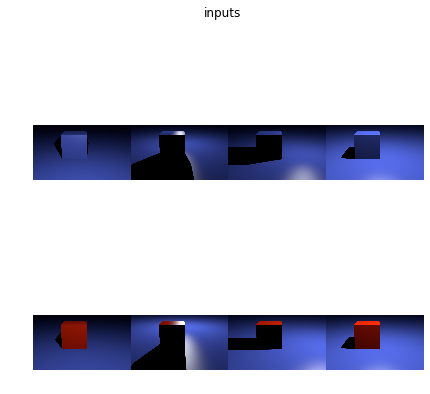

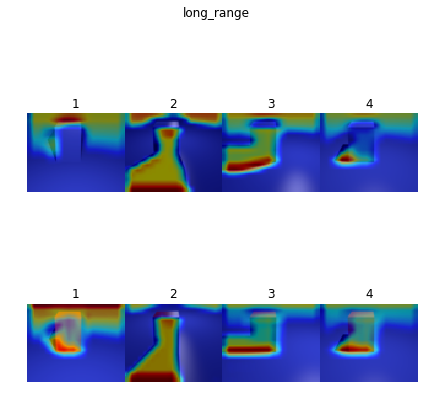

In [38]:
image_paths = [*sorted(glob.glob('images/long_range_perception/equal_color/*')), 
                          *sorted(glob.glob('images/long_range_perception/different_color/*'))]
               
image_paths = filter(lambda x: os.path.isfile(x), image_paths)

images = list(map(lambda x: Image.open(x).convert('RGB'), image_paths))

subplot(images, title='inputs', nrows=2, ncols=4)

plt.show()

inputs  = [pre_processing(x).unsqueeze(0).to(device) for x in images]  # add 1 dim for batch


run_long_range_vis()

The first image represent a realistic situation, while picture 2 has a really strong light from behind that generates a shadow in front of the camera. Picture 3 has a shadow on the left and picture 4 has a little shadow on the left. 

While the big black shadow confuses the model, we can say that in picture 1 and 4, the grad cam highlight better the corners of the red cude. Especially in the first picture, with the frontal light and the cube and ground blue the model is not looking ad the bottom corner.

**Remember** this model is not train as well as the author one since it was out of the scope of this articile. I trained once for around 20 epoches with 80% of the original train dataset.

We can definitily say that this model has some hard time with object with the same colour of the ground. Thanks to this consideration, we could improve the number equal object/ground in the dataset and hopefully increase the robusteness of the robot.